# Preprocessing
Below is a basic preprocessing workflow intended as a proof-of-concept using experimental SQL based methods of AnnSQL. Here, we demonstrate how AnnSQL can be used to preprocess Primary Mouse Culture single-cell sequencing data. **Note**: While, this notebook yields expected results, we consider the preprocessing functionality of AnnSQL to be considered experimental and as the *first* demonstration of how SQL methods can be used for single-cell analysis. 

## Outline
1. Convert to AnnData to AnnSQL
2. Save Raw Counts
3. QC Metrics (total UMIs and gene counts)
4. Filter Libraries
5. Normalization
6. Highly Variable Genes
7. PCA 
8. Clustering (Leiden)
9. UMAP
10. Marker Gene Identification
11. Manual Cell Type Annotation

### Additional Notes
- AnnSQL was build for filtering large datasets with incredible speed using the Duckdb engine. 
- Preprocessing steps below are the *first* SQL-based implementation. We built this functionality as a demonstration rather than a runtime optimized implementation. 
- The methods presented below are *extremely* memory respectful and will run with minimal resources on massive datasets. 
- AnnSQL preprocessing is slower for smaller datasets than Scanpy or Seurat; however, when scaling up to massive datasets, it will run with minimal resource usage. 

## Load the libraries

In [1]:
import os
import scanpy as sc
from AnnSQL import AnnSQL
from AnnSQL.MakeDb import MakeDb

## Convert to AnnSQL
This converts the AnnData object into a AnnSQL database that is stored on disk. Please read more about the options available for creating databases. For large databases, backed mode is fully supported, however it may take time to fully parse and create the database. Be patient. Once the AnnSQL database is created, you will be able to query the database with minimal resources at high speed. 

In [2]:
filepath = "data/PCCM.h5ad"
adata = sc.read_h5ad(filepath)
adata = adata.raw.to_adata()
if os.path.exists("db/PCCM.asql"):
	os.remove("db/PCCM.asql")
MakeDb(adata=adata, db_name="PCCM", db_path="db")

Time to make var_names unique:  14.235388994216919
Time to create X table structure:  0.11473727226257324
Time to insert X data:  9.141429662704468
Finished inserting obs data
Finished inserting var_names data
Finished inserting var data
Finished inserting obsm data
Finished inserting varm data
Finished inserting obsp data
Error inserting key gene_anno: Not implemented Error: Unable to transform python value of type '<class 'pandas.core.frame.DataFrame'>' to DuckDB LogicalType


## Open the AnnSQL object

In [4]:
asql = AnnSQL(db="db/PCCM.asql")

## Save a raw layer
Here we save a copy of the raw counts before moving forward with preprocessings. If we ever have an oopsie, we can use the `asql.raw_to_X()` method to revert to the original state

In [4]:
asql.save_raw()

X_raw table created from X.


## Calculate total UMI counts and total gene counts
If your system has low memory, adjust `chunk_size` parameter lower so the process matches your system capabilties. You'll want to carry a chunk size forward to future steps that works best for your system.

In [5]:
asql.calculate_total_counts(chunk_size=750)
asql.calculate_gene_counts(chunk_size=750) 

Total Counts Calculation Started
Total Counts Calculation Complete
Updating Var Table
Gene Counts Calculation Started
Gene Counts Calculation Complete


## Plot the total UMI and gene counts calculated above

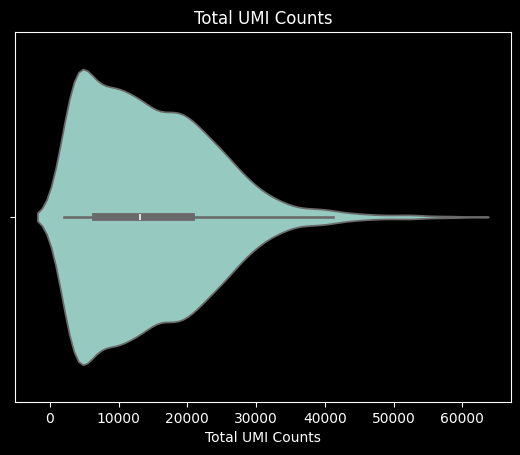

In [6]:
asql.plot_total_counts()

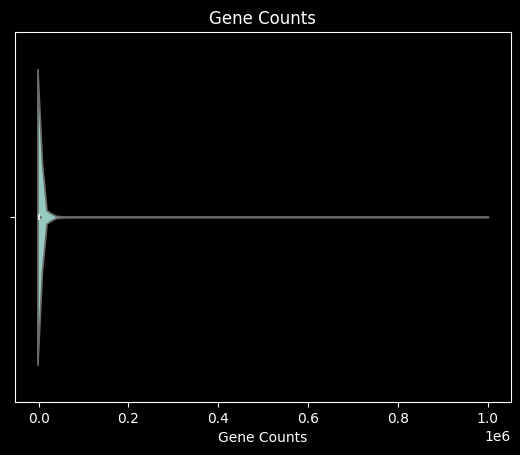

In [7]:
asql.plot_gene_counts()

## Filter low expressing cells and genes

In [8]:
#filter by total umi counts
asql.filter_by_cell_counts(min_cell_count=2500, max_cell_count=40000)
asql.filter_by_gene_counts(min_gene_counts=100, max_gene_counts=10000)

Cells with total counts less than 2500 and greater than 40000 removed
Removed genes with less than 100 and greater than 10000 from X table.


## View the plots after fitlering

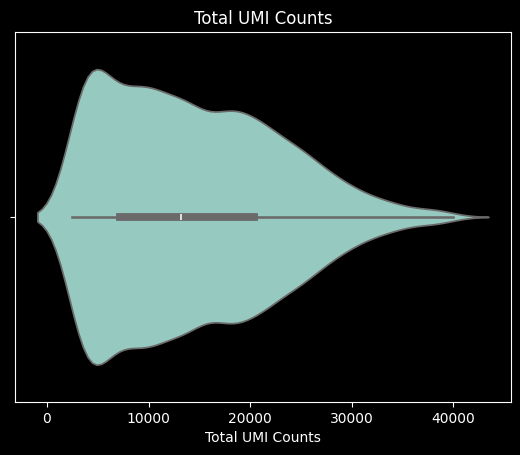

In [9]:
asql.plot_total_counts()

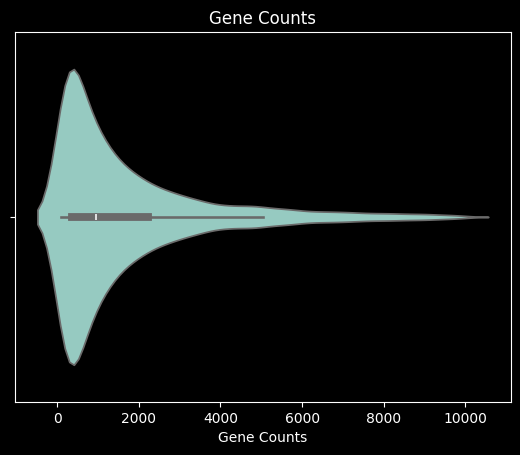

In [10]:
asql.plot_gene_counts()

## Normalize & Log the UMI expression

In [11]:
asql.expression_normalize(total_counts_per_cell=10000, chunk_size=750)
asql.expression_log(log_type="LN", chunk_size=750)

Query Successful
Total Counts Calculation Started
Total Counts Calculation Complete
Expression Normalization Started
Expression Normalization Complete
Log Transform Started
Log Transform Complete


## Determine the highly variable genes

In [12]:
asql.calculate_variable_genes(chunk_size=750, save_var_names=False)

Updating Var Table
Variance Calculation Complete


## Plot the highly variable genes to inform a cutoff

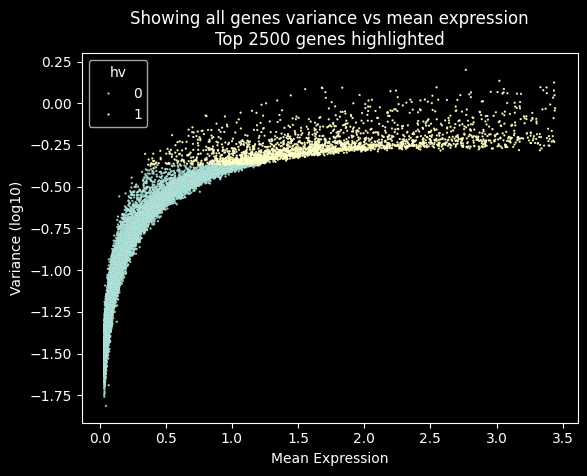

In [13]:
asql.plot_highly_variable_genes(top_variable_genes=2500)

## Save those highly variable genes to the X layer

In [14]:
asql.save_highly_variable_genes(top_variable_genes=2500)

X table updated with only HV genes.


## Perform PCA for dimensionality reduction
For memory tuning, you can also increase or decrease the `max_cells_memory_threshold` parameter. 

In [15]:
asql.calculate_pca(n_pcs=50, top_variable_genes=2500, chunk_size=750, zero_center=False, max_cells_memory_threshold=1000)

PCA Calculation Started

Using SQL method for covariance calculation
Covariance Chunk 0 of 2500
Covariance Chunk 750 of 2500
Covariance Chunk 1500 of 2500
Covariance Chunk 2250 of 2500
PCs Chunk 0 of 2500
PCs Chunk 750 of 2500
PCs Chunk 1500 of 2500
PCs Chunk 2250 of 2500

PCA Calculation Complete



## PCA variance explained by each component

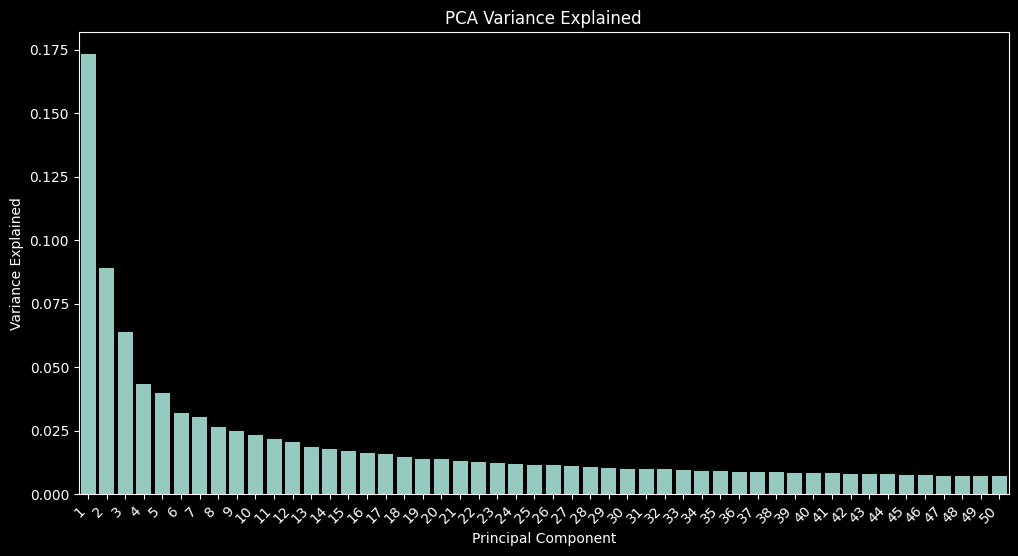

In [16]:
asql.pca_variance_explained()

## Plotting PC1 and PC2

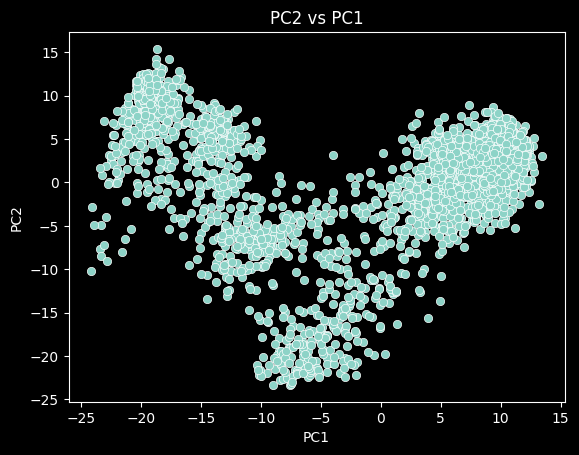

In [17]:
asql.plot_pca(PcX=1, PcY=2)

## Calculate UMAP and Leiden Clusters

In [18]:
asql.calculate_umap()
asql.calculate_leiden_clusters(resolution=0.25, n_neighbors=5)

UMAP embedding calculated.
Leiden clustering complete. Clusters saved in 'obs' as 'leiden_clusters'.


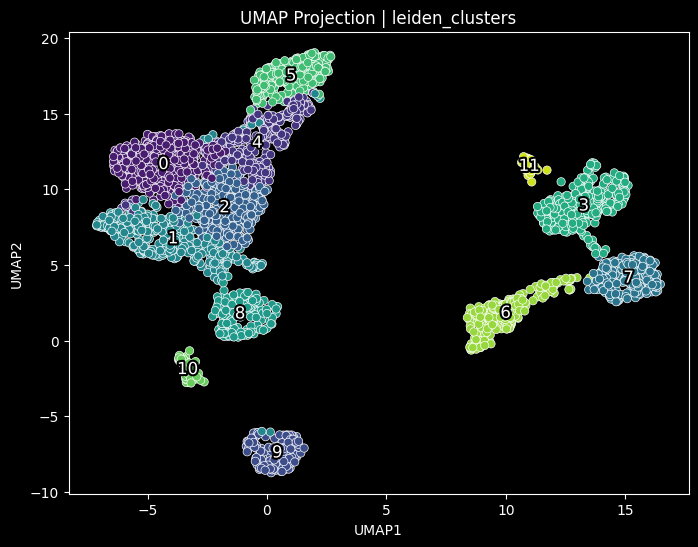

In [19]:
asql.plot_umap(color_by="leiden_clusters", annotate=True)

## Calculate marker genes for each of the clusters

In [20]:
asql.calculate_marker_genes(obs_key="leiden_clusters")

Calculating marker genes for leiden_clusters: 10
DE Calculation Complete.
Calculating marker genes for leiden_clusters: 7
DE Calculation Complete.
Calculating marker genes for leiden_clusters: 3
DE Calculation Complete.
Calculating marker genes for leiden_clusters: 8
DE Calculation Complete.
Calculating marker genes for leiden_clusters: 9
DE Calculation Complete.
Calculating marker genes for leiden_clusters: 4
DE Calculation Complete.
Calculating marker genes for leiden_clusters: 0
DE Calculation Complete.
Calculating marker genes for leiden_clusters: 5
DE Calculation Complete.
Calculating marker genes for leiden_clusters: 1
DE Calculation Complete.
Calculating marker genes for leiden_clusters: 2
DE Calculation Complete.
Calculating marker genes for leiden_clusters: 11
DE Calculation Complete.
Calculating marker genes for leiden_clusters: 6
DE Calculation Complete.
Marker genes calculation complete.
Query the results with:
"SELECT * FROM diff_expression WHERE name='Markers'".


## Plot the marker genes for each cluster.
These marker genes can be used for manual cell type assignment of the leiden clusters. To simply return a list of marker genes for a cluster, you may run the method `asql.get_marker_genes(obs_key="leiden_clusters", group="0")`

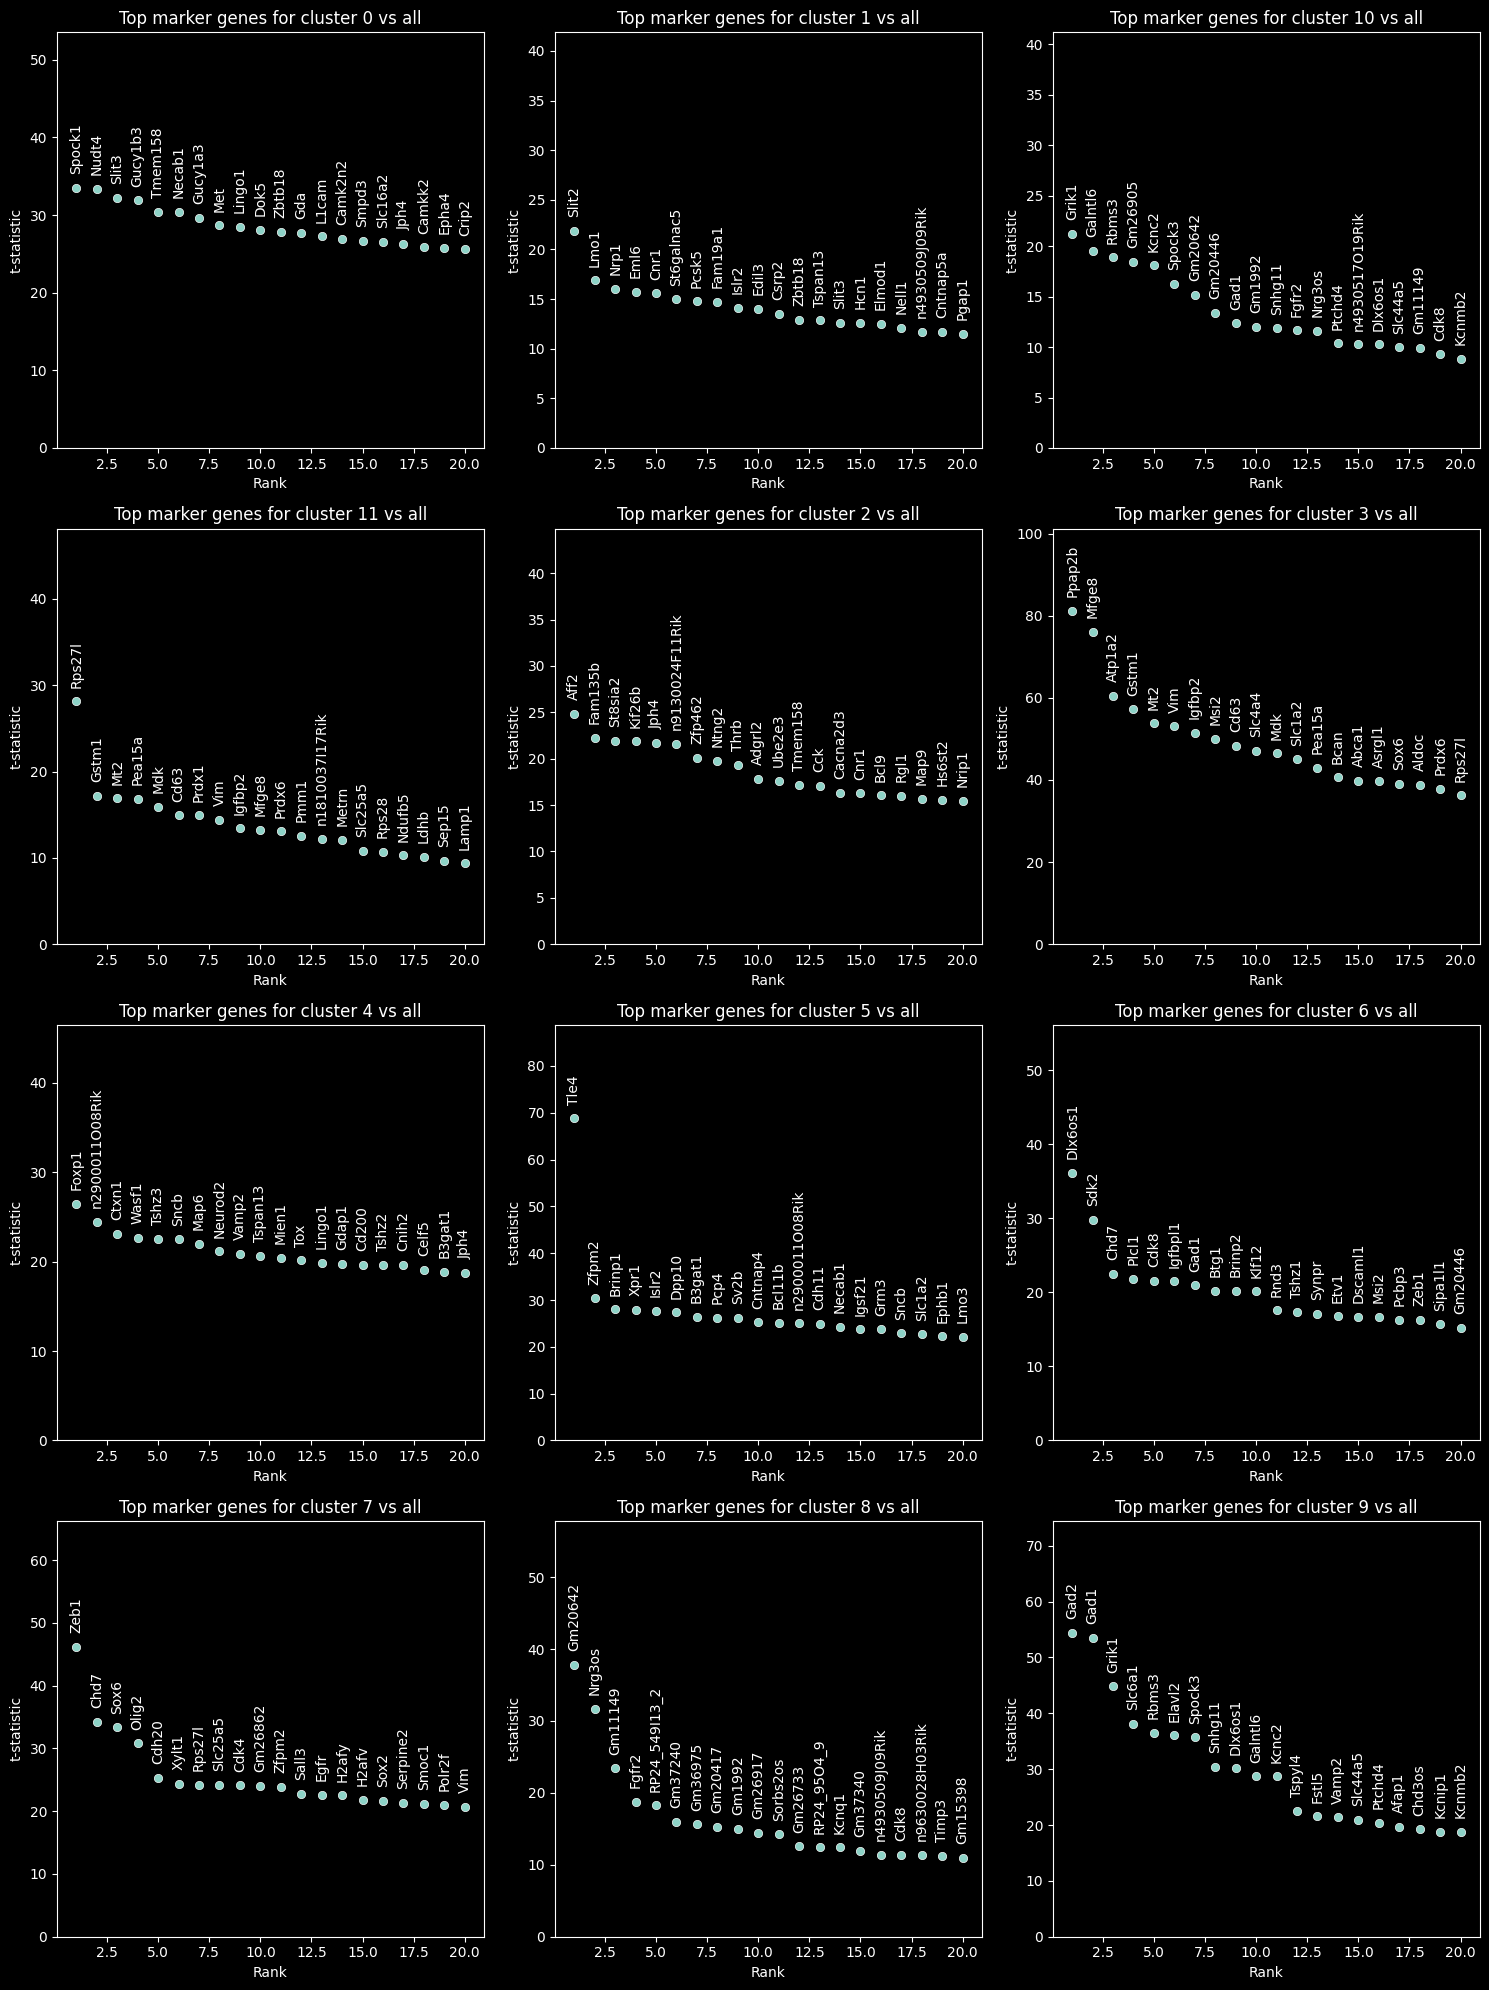

In [21]:
asql.plot_marker_genes(obs_key="leiden_clusters", columns=3)

## Plot some marker genes for manual cell type identification

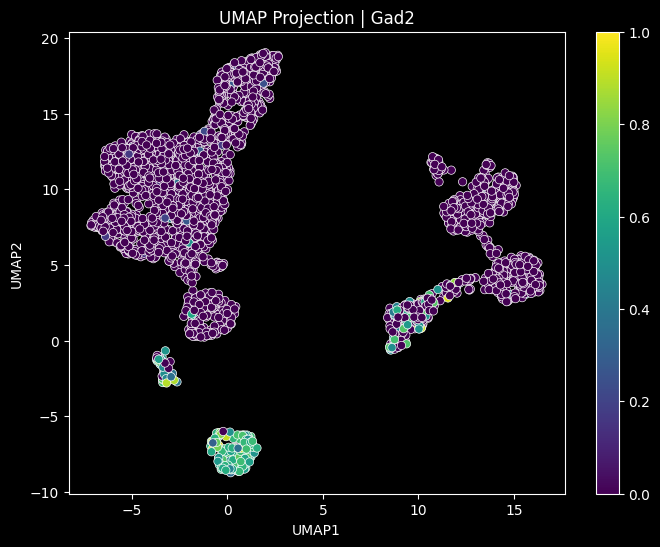

In [3]:
asql.plot_umap(color_by="Gad2")

## Assign cell types to clusters

In [23]:
cell_types = {
	"0":"Glutamatergic",
	"1":"Glutamatergic",
	"2":"Glutamatergic",
	"3":"Astrocytes",
	"4":"Glutamatergic",
	"5":"Glutamatergic",
	"6":"OPCs",
	"7":"Astrocytes",
	"8":"Glutamatergic",
	"9":"Interneurons",
	"10":"Interneurons",
	"11":"Astrocytes",
}

asql.add_observations(obs_key="cell_type", obs_values=cell_types, match_on="leiden_clusters")

cell_type added to obs table!
obs_values keys matched on leiden_clusters.


## Plot UMAP of cell types

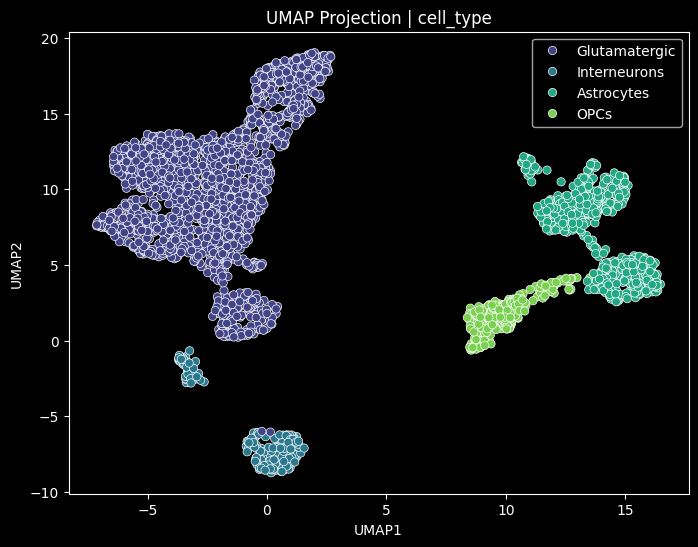

In [24]:
asql.plot_umap(color_by="cell_type", legend_location="best")

## Differential Expression between two groups

In [5]:
asql.calculate_differential_expression(obs_key="cell_type", group1_value="Glutamatergic", group2_value="Interneurons", drop_table=False)

DE Calculation Complete.


## Plot the Differential Expression between groups

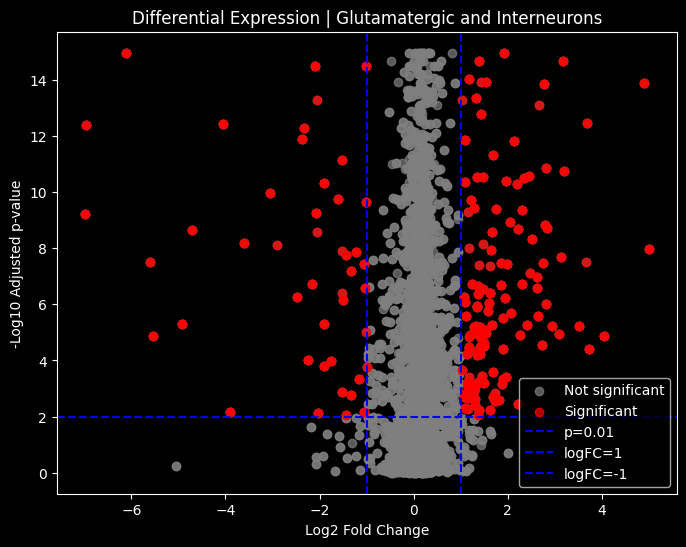

Query the results with:
"SELECT * FROM diff_expression WHERE group1='Glutamatergic' and group2='Interneurons'".


In [8]:
asql.plot_differential_expression(pvalue_threshold=0.01, logfc_threshold=1, group1="Glutamatergic", group2="Interneurons")

## Query the differentially expressed genes 

In [19]:
asql.query("SELECT * FROM diff_expression WHERE group1='Glutamatergic' and group2='Interneurons'")

,name,group1,group2,gene,tstat,logfc,df,pval,adj_pval
0,None,Glutamatergic,Interneurons,n0610007P14Rik,9.510554,0.690482,244.745049,0.000000,8.522932e-10
1,None,Glutamatergic,Interneurons,n0610010F05Rik,1.675895,0.108692,232.748270,0.095102,7.748346e-02
2,None,Glutamatergic,Interneurons,n1110001J03Rik,-4.102522,-0.383268,226.199692,0.000057,1.795565e-10
3,None,Glutamatergic,Interneurons,n1110008F13Rik,1.368839,0.103808,234.379478,0.172360,7.985383e-08
4,None,Glutamatergic,Interneurons,n1110008P14Rik,4.716690,0.385441,242.931060,0.000004,3.083596e-08
...,...,...,...,...,...,...,...,...,...
4995,None,Glutamatergic,Interneurons,Zrsr2,-1.943491,-0.167129,228.517537,0.053185,7.144190e-01
4996,None,Glutamatergic,Interneurons,Zyg11b,4.248372,0.274033,229.425298,0.000031,0.000000e+00
4997,None,Glutamatergic,Interneurons,Zzef1,-1.031112,-0.095388,232.395308,0.303560,6.500337e-12
4998,None,Glutamatergic,Interneurons,l7Rn6,0.669094,0.064054,230.303967,0.504106,2.791669e-03
